In [2]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import math
from utils import *
import argparse
from matplotlib.legend_handler import HandlerLine2D
from utils import *
from model import *
from data import *

In [3]:
# 批量预测
def last_word_acc(model, data, batch_size=-1, b=0):
    # 如果预测的最后一个词跟句子的最后一个词一样，视为预测正确
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    data = np.array(data)
    if batch_size == -1:
        batch_size = np.size(data, 0)
    train_dataset = MyDataSet(data)
    data_loader = Data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, 
                                        drop_last=False, collate_fn=train_dataset.padding_batch)
    
    for i, (dec_inputs, dec_outputs) in enumerate(data_loader):  
        dec_inputs, dec_outputs = dec_inputs.to(device), dec_outputs.to(device)
        outputs, _ = model(dec_inputs) 
        outputs = outputs.argmax(axis=-1).view(-1, np.size(data, 1)-1)
        correct += (outputs[:, -1] == dec_outputs[:, -1]+b).sum().item()

    return correct / len(data_loader.dataset) 

In [4]:
exp_dir = '../result/GPT_每个anchor有各自的区间'
working_dir = f'{exp_dir}/multianchor_multiinterval-seed_1-N_20000-4L4H_lr1e-4'
state_dict=torch.load(f'{working_dir}/model/model_440.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = load_args(f'{working_dir}/config.json')

model = myGPT(args, device)
model.load_state_dict(state_dict)
model.to(device)

myGPT(
  (decoder): Decoder(
    (tgt_emb): Embedding(201, 400)
    (pos_emb): Embedding(20, 400)
    (layers): ModuleList(
      (0-7): 8 x DecoderLayer(
        (dec_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=400, out_features=384, bias=False)
          (W_K): Linear(in_features=400, out_features=384, bias=False)
          (W_V): Linear(in_features=400, out_features=384, bias=False)
          (fc): Linear(in_features=384, out_features=400, bias=False)
          (layernorm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        )
        (pos_ffn): PoswiseFeedForwardNet(
          (fc): Sequential(
            (0): Linear(in_features=400, out_features=1200, bias=False)
            (1): ReLU()
            (2): Linear(in_features=1200, out_features=400, bias=False)
          )
          (layernorm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
  )
  (projection): Linear(in_features=400, out_features=201, bias=True)
)

各anchor在seen和unseen interval的准确率

In [5]:
args.train_data_size = 1000
args.test_data_size = 0
train_acc_list = []
test_acc_list = []
for i in range(1, 11):
    for c in ['False', 'True']:
        kwargs = {'use_mod_list_specific': 'True', 'prompt': f'{i}', 'unseen interval': c}
        datas = get_data(args, True, **kwargs)

        train_data = datas['train_seq_group']
        # test_data = datas['test_seq_group']

        train_acc = last_word_acc(model, train_data['full data'], batch_size=1000, b=0)
        # test_acc = last_word_acc(model, test_data['full data'], batch_size=1000, b=0)

        # print(f'prompt: {i}, unseen interval: {c}, train acc: {train_acc}, test acc: {test_acc}')

        print(f'prompt: {i}, unseen interval: {c}, train acc: {train_acc}')

        train_acc_list.append(train_acc)
        # test_acc_list.append(test_acc)

train_acc_list = np.array(train_acc_list).reshape((10, 2))
# test_acc_list = np.array(test_acc_list).reshape((10, 2))


/nfs/my/data/anchor_function_for_public/paper_plot_code/../data.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  decoder_inputs = torch.tensor([d["decoder_input"] for d in batch], dtype=torch.long)


prompt: 1, unseen interval: False, train acc: 1.0
prompt: 1, unseen interval: True, train acc: 0.851
prompt: 2, unseen interval: False, train acc: 1.0
prompt: 2, unseen interval: True, train acc: 0.868
prompt: 3, unseen interval: False, train acc: 0.998
prompt: 3, unseen interval: True, train acc: 1.0
prompt: 4, unseen interval: False, train acc: 0.998
prompt: 4, unseen interval: True, train acc: 0.999
prompt: 5, unseen interval: False, train acc: 0.999
prompt: 5, unseen interval: True, train acc: 0.994
prompt: 6, unseen interval: False, train acc: 0.998
prompt: 6, unseen interval: True, train acc: 0.998
prompt: 7, unseen interval: False, train acc: 0.999
prompt: 7, unseen interval: True, train acc: 0.996
prompt: 8, unseen interval: False, train acc: 0.999
prompt: 8, unseen interval: True, train acc: 0.998
prompt: 9, unseen interval: False, train acc: 1.0
prompt: 9, unseen interval: True, train acc: 0.992
prompt: 10, unseen interval: False, train acc: 1.0
prompt: 10, unseen interval: T

In [6]:
def plot_multiinterval_acc():
    fig = plt.figure(figsize=(12, 6))
    format_settings(left=0.18, right=0.98, bottom=0.18, top=0.88, major_tick_len=5, major_tick_width=2, fs=32, axlw=2)
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    width=0.35
    plt.bar(np.arange(10)-width/2, train_acc_list[:, 0], width=width, label=r'$x\in G_a$', edgecolor='black', linewidth=2)
    plt.bar(np.arange(10)+width/2, train_acc_list[:, 1], width=width, label=r'$x\in G_a^c$', edgecolor='black', linewidth=2)
    plt.xticks(np.arange(10), np.arange(1, 11))
    plt.yticks([0.2, 0.6, 1.0], ['20%', '60%', '100%'])
    plt.xlabel('Anchor')
    plt.ylabel('Accuracy')

    plt.legend(loc=(0, 1.02), frameon=False, ncol=2, fontsize=24)
    plt.savefig(f'{working_dir}/acc.png', dpi=300)
    print(f'saved at {working_dir}/acc.png')
    plt.show()

saved at ../result/GPT_每个anchor有各自的区间/multianchor_multiinterval-seed_1-N_20000-4L4H_lr1e-4/acc.png


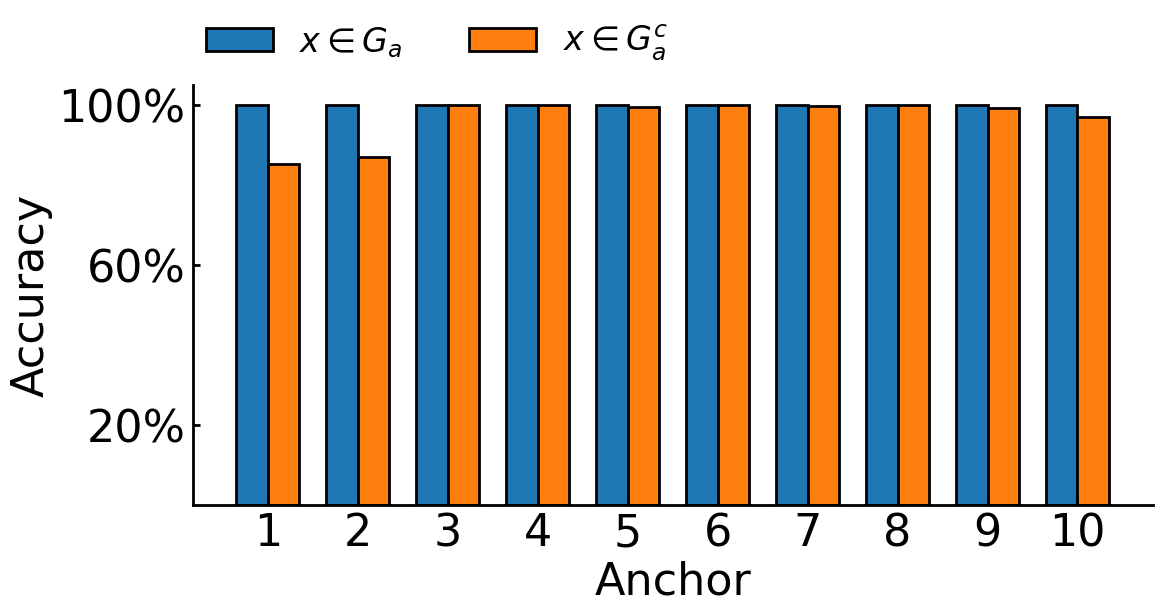

In [7]:
plot_multiinterval_acc()